Saving scaler for case upstairs to scaler_upstairs.pkl
Saving scaler for case downstairs to scaler_downstairs.pkl
Dropped 0 rows
Number of rows dropped for Slip: 0
Number of rows dropped for Trip: 0
Number of rows dropped for Walking: 0
Number of groups: 52
Maximum timesteps: 147
Minimum timesteps: 14
Training data count: 154
Test data count: 39
Number of timesteps: 147
Number of features: 34
Number of class labels: 3


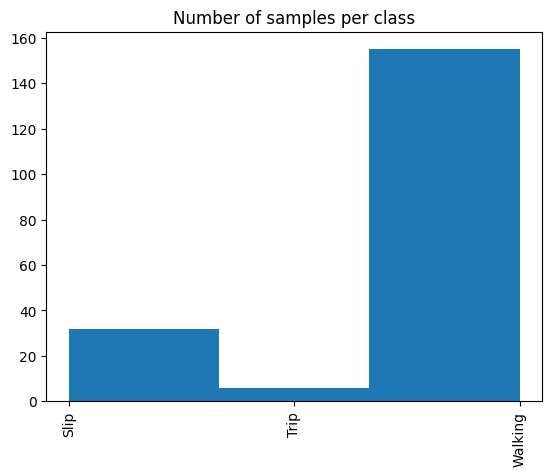

In [41]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras._tf_keras.keras.utils import pad_sequences

# Optimize gpu memory
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Load the dataset
file_path = '../../dataset_primer/edited/lstm_dataset_with_cases.csv'
df = pd.read_csv(file_path)

# # Normalize the features (optional)
features = df.columns[:-5]  # Exclude 'segment_index', 'person_index', 'frame_index', 'label', 'case'
# scaler = MinMaxScaler()
# df[features] = scaler.fit_transform(df[features])

# # Save the scaler for later use
# scaler_filename = "lstm_scaler_V2.pkl"
# joblib.dump(scaler, scaler_filename)

## TODO: Scale stairs up and down independently
def scale_and_save_per_case(df, features):
    scalers = {}
    for case in df['case'].unique():
        case_df = df[df['case'] == case]
        scaler = MinMaxScaler()
        df.loc[df['case'] == case, features] = scaler.fit_transform(case_df[features])
        scalers[case] = scaler
        # Save the scaler for the specific case
        scaler_filename = f"scaler_{case}.pkl"
        print(f"Saving scaler for case {case} to {scaler_filename}")
        joblib.dump(scaler, scaler_filename)
    return df, scalers

# Apply scaling and save scalers
df, scalers = scale_and_save_per_case(df, features)

# Filter out rows with all zero keypoints or specific keypoints being zero
dropped_rows_count = {label: 0 for label in df['label'].unique()}

def filter_keypoints(row):
    # keypoints = row[features].values
    # if np.all(keypoints == 0):
    #     dropped_rows_count[row['label']] += 1
    #     return False
    # if np.any(keypoints[[features.get_loc(k) for k in [
    #     'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x', 'right_shoulder_y',
    #     'left_hip_x', 'left_hip_y', 'right_hip_x', 'right_hip_y',
    #     'left_knee_x', 'left_knee_y', 'right_knee_x', 'right_knee_y',
    #     'left_ankle_x', 'left_ankle_y', 'right_ankle_x', 'right_ankle_y'
    # ]]] == 0):
    #     dropped_rows_count[row['label']] += 1
    #     return False
    return True

# Calculate dropped rows
before_rows = len(df)
df = df[df.apply(filter_keypoints, axis=1)]
print(f"Dropped {before_rows - len(df)} rows")

# Print the dropped rows count for each label
for label, count in dropped_rows_count.items():
    print(f"Number of rows dropped for {label}: {count}")


# Group by segment_index and person_index
grouped = df.groupby(['segment_index', 'person_index'])
print(f"Number of groups: {len(grouped)}")

# Create sequences
MIN_TIMESTEPS = 10
MAX_TIMESTEPS = 20
sequences = []
labels = []
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
for (segment_index, person_index), group in grouped:
    group_data = group[features].values
    label = group['label'].iloc[0]
    if label == "Walking":
        # Create sequences of MAX_TIMESTEPS frames for each person_index
        for i in range(0, len(group_data), MAX_TIMESTEPS):
            seq = group_data[i:i + MAX_TIMESTEPS]
            if len(seq) == MAX_TIMESTEPS:
                sequences.append(seq)
                labels.append(label_mapping[label])
    else:
        if len(group_data) >= MIN_TIMESTEPS:
            sequences.append(group_data)
            labels.append(label_mapping[label])

# Pad sequences to the same length
max_timesteps = max(len(seq) for seq in sequences)
min_timesteps = min(len(seq) for seq in sequences)
print(f"Maximum timesteps: {max_timesteps}")
print(f"Minimum timesteps: {min_timesteps}")
sequences = pad_sequences(sequences, maxlen=max_timesteps, dtype='float32', padding='post', truncating='post')

# Convert labels to numpy array
labels = np.array(labels)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=123)

training_data_count = len(x_train)
test_data_count = len(x_test)
n_steps = len(x_train[0])
n_input = len(x_test[0][0])
print(f"Training data count: {training_data_count}")
print(f"Test data count: {test_data_count}")
print(f"Number of timesteps: {n_steps}")
print(f"Number of features: {n_input}")
print(f"Number of class labels: {len(label_mapping)}")

# Plot number of samples per class
import matplotlib.pyplot as plt
plt.hist(labels, bins=len(label_mapping))
plt.xticks(range(len(label_mapping)), label_mapping.keys(), rotation=90)
plt.title("Number of samples per class")
plt.show()

In [2]:
## Hyperparameter optimization ##
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Input, Conv1D, BatchNormalization, Bidirectional, LSTM, Dropout, Dense
from keras._tf_keras.keras.regularizers import l2
from keras_tuner import HyperModel, Objective
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(max_timesteps, len(features))))  # Explicitly define input shape here
        model.add(Conv1D(
            filters=hp.Int('conv_filters', min_value=32, max_value=128, step=16),
            kernel_size=3,
            activation='relu',
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(Bidirectional(LSTM(
            units=hp.Int('lstm_units_1', min_value=64, max_value=256, step=32),
            return_sequences=True
        )))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(
            units=hp.Int('lstm_units_2', min_value=64, max_value=256, step=32)
        )))
        # Add output layer and more layers as needed
        model.add(Dropout(0.2))
        model.add(Dense(
            units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
            activation='relu',
            # kernel_regularizer=l2(0.01)
            kernel_regularizer=l2(hp.Choice('l2', values=[0.01, 0.001, 0.0001]))
        ))
        model.add(Dropout(0.3))
        model.add(Dense(len(label_mapping), activation='softmax'))

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', 'sparse_categorical_crossentropy'])
        
        return model

# Instantiate the tuner
tuner = RandomSearch(
    MyHyperModel(),
    objective=Objective('val_loss', direction='min'),
    # objective=Objective('val_sparse_categorical)_crossentropy', direction='min'),
    max_trials=100,
    executions_per_trial=1,
    directory='param_opt',
    project_name='lstm_tuning'
)

# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")


Trial 100 Complete [00h 00m 15s]
val_loss: 0.12569177150726318

Best val_loss So Far: 0.08736412227153778
Total elapsed time: 00h 24m 39s
Best hyperparameters:
conv_filters: 48
lstm_units_1: 160
lstm_units_2: 96
dense_units: 128
l2: 0.0001


/home/e206/miniconda3/envs/pri3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
## Training callbacks tuning ##
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Input, Conv1D, BatchNormalization, Bidirectional, LSTM, Dropout, Dense
from keras._tf_keras.keras.regularizers import l2
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from keras._tf_keras.keras.callbacks import ReduceLROnPlateau, EarlyStopping

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(max_timesteps, len(features))))  # Explicitly define input shape here
        model.add(Conv1D(
            filters=48,
            kernel_size=3,
            activation='relu',
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(Bidirectional(LSTM(
            units=160,
            return_sequences=True
        )))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(
            units=96
        )))
        model.add(Dropout(0.3))
        model.add(Dense(
            units=128,
            activation='relu',
            kernel_regularizer=l2(hp.Choice('l2', values=[0.01, 0.001, 0.0001]))
        ))

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', 'sparse_categorical_crossentropy'])
        model.summary()

        return model

# Instantiate the tuner
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='param_opt',
    project_name='early_stop'
)

def search_with_callbacks(hp):
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=hp.Float('reduce_lr_factor', min_value=0.1, max_value=0.5, step=0.1),
        patience=hp.Int('reduce_lr_patience', min_value=3, max_value=10, step=2),
        min_lr=1e-6,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=hp.Choice('early_stop_patience', values=[5, 10, 15]),
        min_delta=hp.Choice('early_stop_min_delta', values=[0.001, 0.005, 0.01]),
        restore_best_weights=True,
        verbose=1
    )

    tuner.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[reduce_lr, early_stop])

search_with_callbacks(tuner.oracle.hyperparameters)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Trial 20 Complete [00h 00m 05s]
val_loss: 0.5725656151771545

Best val_loss So Far: 0.5725656151771545
Total elapsed time: 00h 01m 38s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 48)         │         4,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 48)         │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 320)        │       267,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 320)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 192)            │       320,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        24,704 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,616 (2.36 MB)

 Trainable params: 617,520 (2.36 MB)

 Non-trainable params: 96 (384.00 B)

Best hyperparameters:
l2: 0.0001
reduce_lr_factor: 0.2
reduce_lr_patience: 7
early_stop_patience: 15
early_stop_min_delta: 0.01


/home/e206/miniconda3/envs/pri3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import LSTM, Dropout, Dense, Bidirectional, Conv1D, BatchNormalization
from keras._tf_keras.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.regularizers import l2

# Define the LSTM model
model = Sequential([
    # First Bidirectional LSTM layer with Conv1D + MaxPooling for feature extraction
    Conv1D(64, 3, activation='relu', padding='same', input_shape=(max_timesteps, len(features))),
    BatchNormalization(),
    
    # Bidirectional LSTM for better learning of sequential data
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),

    # Second Bidirectional LSTM for deeper sequence learning
    Bidirectional(LSTM(128)),
    Dropout(0.2),
    
    # Fully connected dense layers
    Dense(128, activation='relu', kernel_regularizer=l2(0.02)),
    Dropout(0.3),
    
    # Output layer for classification (using softmax for multi-class classification)
    Dense(len(label_mapping), activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.005, restore_best_weights=True, verbose=1)

/home/e206/miniconda3/envs/pri3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734848688.445142 3084584 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21976 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 140, 64)        │         6,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 140, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 140, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 140, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 632,003 (2.41 MB)

 Trainable params: 631,875 (2.41 MB)

 Non-trainable params: 128 (512.00 B)

In [18]:
## MODEL V2 from hyper param opt ##
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import LSTM, Dropout, Dense, Bidirectional, Conv1D, BatchNormalization
from keras._tf_keras.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.regularizers import l2

# Define the LSTM model
model = Sequential([
    # First Bidirectional LSTM layer with Conv1D + MaxPooling for feature extraction
    Conv1D(48, 3, activation='relu', padding='same', input_shape=(max_timesteps, len(features))),
    BatchNormalization(),
    
    # Bidirectional LSTM for better learning of sequential data
    Bidirectional(LSTM(160, return_sequences=True)),
    Dropout(0.2),

    # Second Bidirectional LSTM for deeper sequence learning
    Bidirectional(LSTM(96)),
    Dropout(0.2),
    
    # Fully connected dense layers
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    
    # Output layer for classification (using softmax for multi-class classification)
    Dense(len(label_mapping), activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-9, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.005, restore_best_weights=True, verbose=1)

/home/e206/miniconda3/envs/pri3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 139, 48)        │         4,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 139, 48)        │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 139, 320)       │       267,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 139, 320)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 192)            │       320,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 618,003 (2.36 MB)

 Trainable params: 617,907 (2.36 MB)

 Non-trainable params: 96 (384.00 B)

In [20]:
history = model.fit(x_train, y_train, epochs=400, validation_split=0.2, callbacks=[reduce_lr, early_stop])
# history = model.fit(x_train, y_train, epochs=400, validation_split=0.2)
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9945 - loss: 0.0272 - val_accuracy: 0.9118 - val_loss: 0.2837 - learning_rate: 4.0000e-05
Epoch 2/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0215 - val_accuracy: 0.9118 - val_loss: 0.2817 - learning_rate: 4.0000e-05
Epoch 3/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0199 - val_accuracy: 0.9118 - val_loss: 0.2825 - learning_rate: 4.0000e-05
Epoch 4/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0199 - val_accuracy: 0.9118 - val_loss: 0.2870 - learning_rate: 4.0000e-05
Epoch 5/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0219 - val_accuracy: 0.9118 - val_loss: 0.2927 - learning_rate: 4.0000e-05
Epoch 6/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0224 - val_accuracy: 0.9118 - val_loss: 0.2999 - learning_rate: 4.0000e-05
Epoch 7/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss:

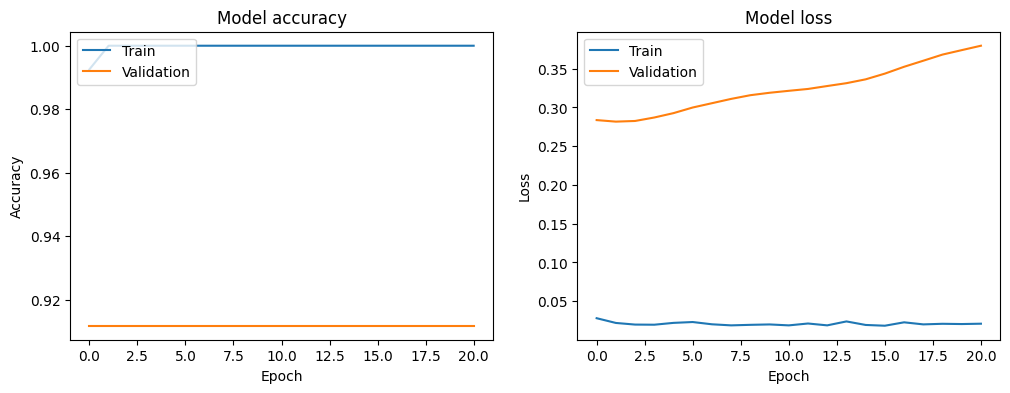

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


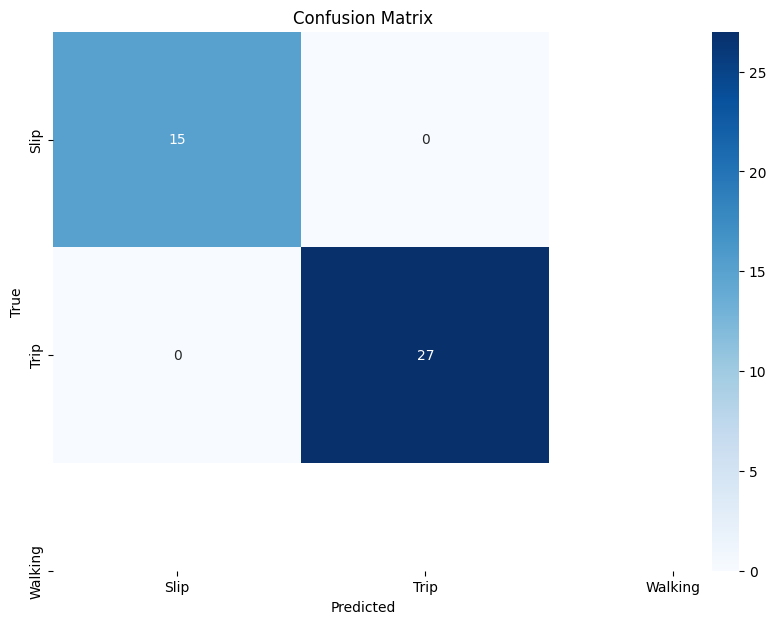

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict the labels for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [16]:
# Save the model
model.save('slip_fall_detector_V2_with-cases.keras')